In [93]:
import sys
import os.path as op
from glob import glob
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import interp1d
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from patsy import dmatrix
from sklearn.cluster import HDBSCAN

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

sys.path.append(op.join(op.expanduser("~"), "code", "style"))
from colors import get_colors

co, palettes = get_colors()

from general.array import array_operations as aop
from general.basic.config import get_plot_defaults, set_rcparams

mpl.rcParams = set_rcparams(mpl.rcParams)
mpl.rcParams["axes.grid"] = False
d = get_plot_defaults()
co = d.get("colors", None)
colws = d.get("colws", None)
font = d.get("font", None)
lws = d.get("lws", None)
pad = d.get("pad", None)
palettes = d.get("palettes", None)
from general.basic.helper_funcs import *
from general.basic.str_methods import *
import general.nifti.nifti_ops as nops

In [2]:
# Get paths to relevant directories.
proc_date = "2023-12-20"
proj_dir = op.join(op.expanduser("~"), "box/projects/leads_tau_spread")
ssheet_dir = op.join(proj_dir, "data", "ssheets")
loni_dir = op.join(ssheet_dir, "loni", f"download_{proc_date}")
fig_dir = op.join(proj_dir, "figs", "hai_2024")

In [126]:
from sklearn.datasets import load_digits
X, Y = load_digits(return_X_y=True)
hdb = HDBSCAN(min_cluster_size=20)
hdb.fit(X)
# hdb.labels_, hdb.probabilities_
digits = pd.DataFrame(np.vstack((hdb.labels_, Y)).T, columns=["cluster", "digit"])
digits.groupby(["cluster", "digit"]).size().unstack().fillna(0).astype(int)

digit,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
-1,10,115,110,98,67,142,35,46,162,129
0,0,0,0,0,0,0,0,133,0,0
1,0,0,0,0,114,0,0,0,0,0
2,168,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,146,0,0,0
4,0,0,0,0,0,40,0,0,0,0
5,0,0,0,85,0,0,0,0,1,51
6,0,67,0,0,0,0,0,0,11,0
7,0,0,67,0,0,0,0,0,0,0


In [134]:
datw.T.index.values

array(['L_amygdala', 'L_bankssts', 'L_caudalanteriorcingulate',
       'L_caudalmiddlefrontal', 'L_cuneus', 'L_entorhinal',
       'L_frontalpole', 'L_fusiform', 'L_hippocampus',
       'L_inferiorparietal', 'L_inferiortemporal', 'L_insula',
       'L_isthmuscingulate', 'L_lateraloccipital',
       'L_lateralorbitofrontal', 'L_lingual', 'L_medialorbitofrontal',
       'L_middletemporal', 'L_paracentral', 'L_parahippocampal',
       'L_parsopercularis', 'L_parsorbitalis', 'L_parstriangularis',
       'L_pericalcarine', 'L_postcentral', 'L_posteriorcingulate',
       'L_precentral', 'L_precuneus', 'L_rostralanteriorcingulate',
       'L_rostralmiddlefrontal', 'L_superiorfrontal',
       'L_superiorparietal', 'L_superiortemporal', 'L_supramarginal',
       'L_temporalpole', 'L_transversetemporal', 'R_amygdala',
       'R_bankssts', 'R_caudalanteriorcingulate', 'R_caudalmiddlefrontal',
       'R_cuneus', 'R_entorhinal', 'R_frontalpole', 'R_fusiform',
       'R_hippocampus', 'R_inferiorpari

In [213]:
dat.query("(roi!=['L_hippocampus', 'R_hippocampus'])")

,subj,roi,suvr,zsuvr
0,LDS0070166,L_amygdala,1.933520,-0.750227
1,LDS0070174,L_amygdala,1.328686,-1.025820
2,LDS0070199,L_amygdala,1.727129,0.293994
3,LDS0070243,L_amygdala,1.619346,-0.193377
4,LDS0070263,L_amygdala,1.556506,-1.169200
...,...,...,...,...
27283,LDS9410572,R_transversetemporal,1.355499,-0.817771
27284,LDS9410574,R_transversetemporal,1.145423,-1.369856
27285,LDS9410608,R_transversetemporal,1.085878,-1.223841
27286,LDS9410622,R_transversetemporal,0.951974,-0.686270


Saved /Users/dschonhaut/box/projects/leads_tau_spread/figs/clustering/hclus_corrmat_suvr_35bilat-fsroi_379eoad_visit1_2024-02-15.pdf


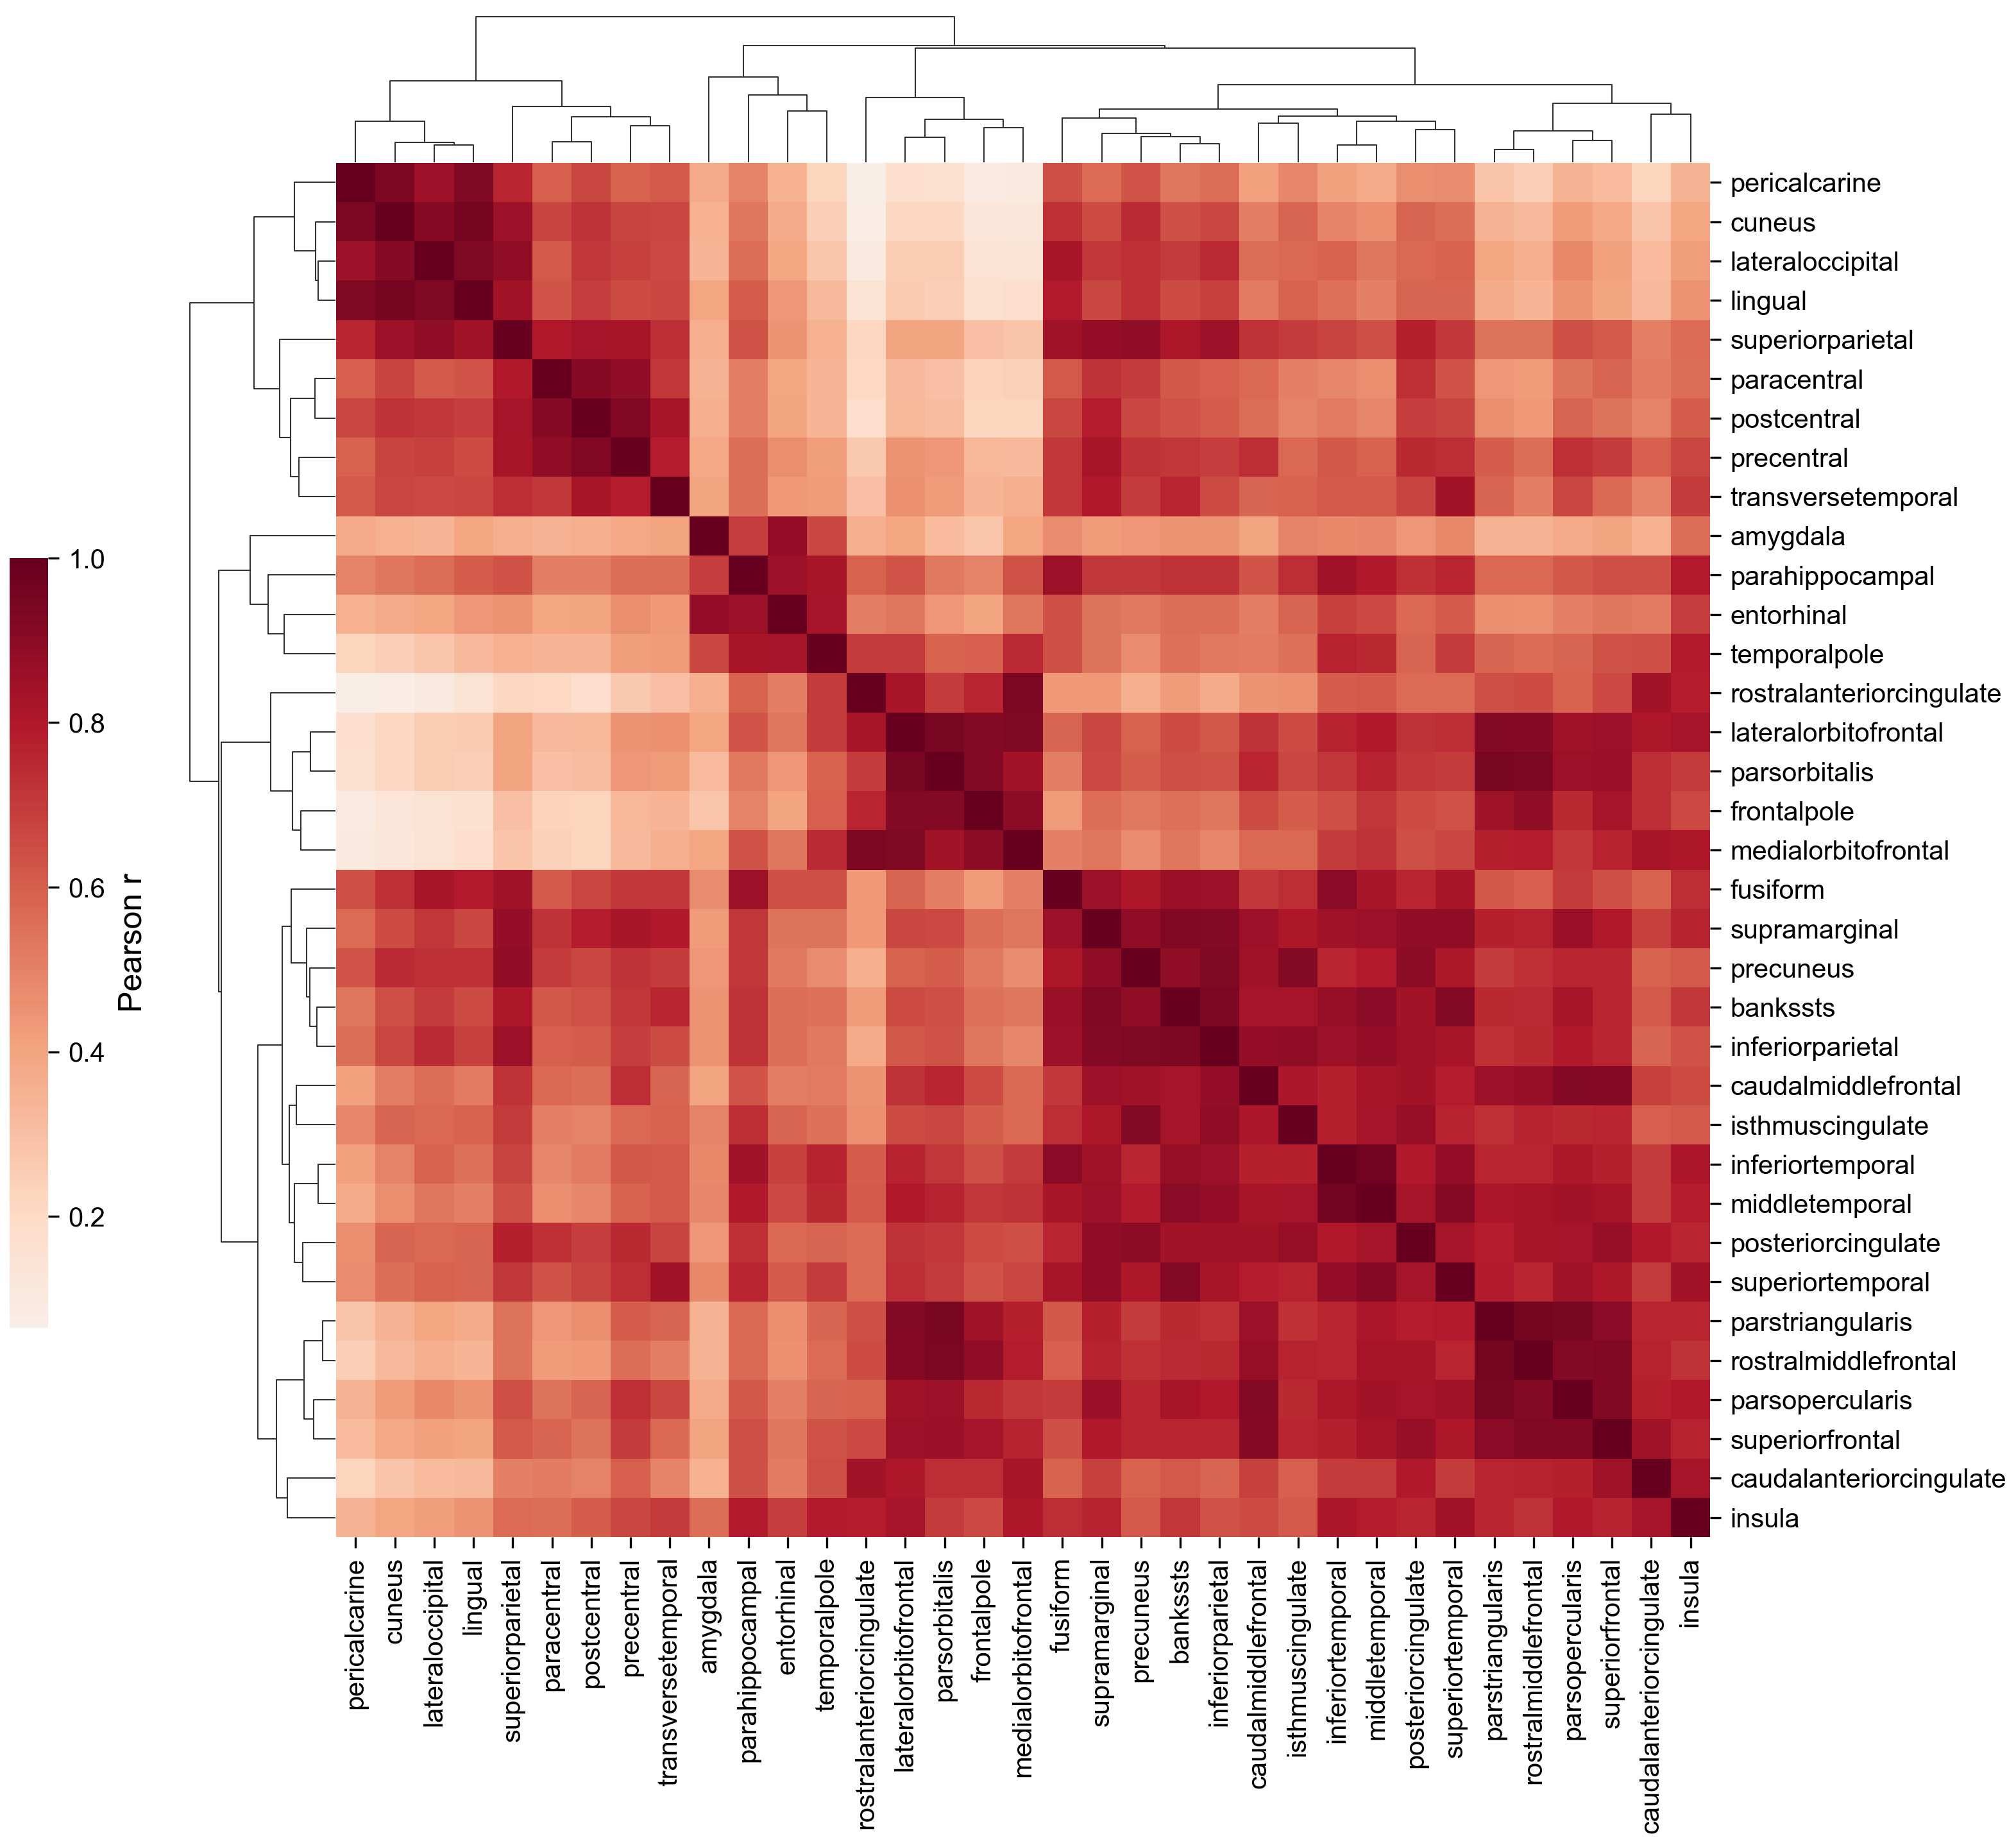

In [251]:
savefig = True
overwrite = True
keep_parcs = ["fsroi_bilat"]
cols = ["subj", "roi", "suvr"]
dat = tau_all_agg.query("(dx=='EOAD') & (parc in @keep_parcs) & (roi!='hippocampus') & (visit==1)").loc[:, cols].reset_index(drop=True).copy()

# Z-score the data within subject.
dat["zsuvr"] = dat.groupby("subj")["suvr"].transform(stats.zscore)

# Plot a correlation matrix of zsuvr values across levels of dat["roi"] with hierarchical clustering.
corrdat = dat.pivot(index="subj", columns="roi", values="suvr").corr()
plt.close("all")
# sns.heatmap(corrdat, cmap="RdBu_r", center=0, square=True, cbar_kws={"label": "Pearson r"})
cg = sns.clustermap(
    corrdat,
    cmap="RdBu_r",
    center=0,
    figsize=(10, 10),
    dendrogram_ratio=(.1, .1),
    cbar_pos=(-0.075, .3, .02, .4),
    cbar_kws={"label": "Pearson r"},
)
# Drop the axis titles
cg.ax_heatmap.set_xlabel("")
cg.ax_heatmap.set_ylabel("")

# Save the figure.
if savefig:
    outf = op.join(proj_dir, "figs", "clustering", "hclus_corrmat_suvr_{}bilat-fsroi_{}eoad_visit1_{}.pdf".format(dat["roi"].nunique(), dat["subj"].nunique(), today()))
    if overwrite or not op.isfile(outf):
        cg.savefig(outf)
        print(f"Saved {outf}")

Saved /Users/dschonhaut/box/projects/leads_tau_spread/figs/clustering/hclus_corrmat_zsuvr_35bilat-fsroi_379eoad_visit1_2024-02-15.pdf


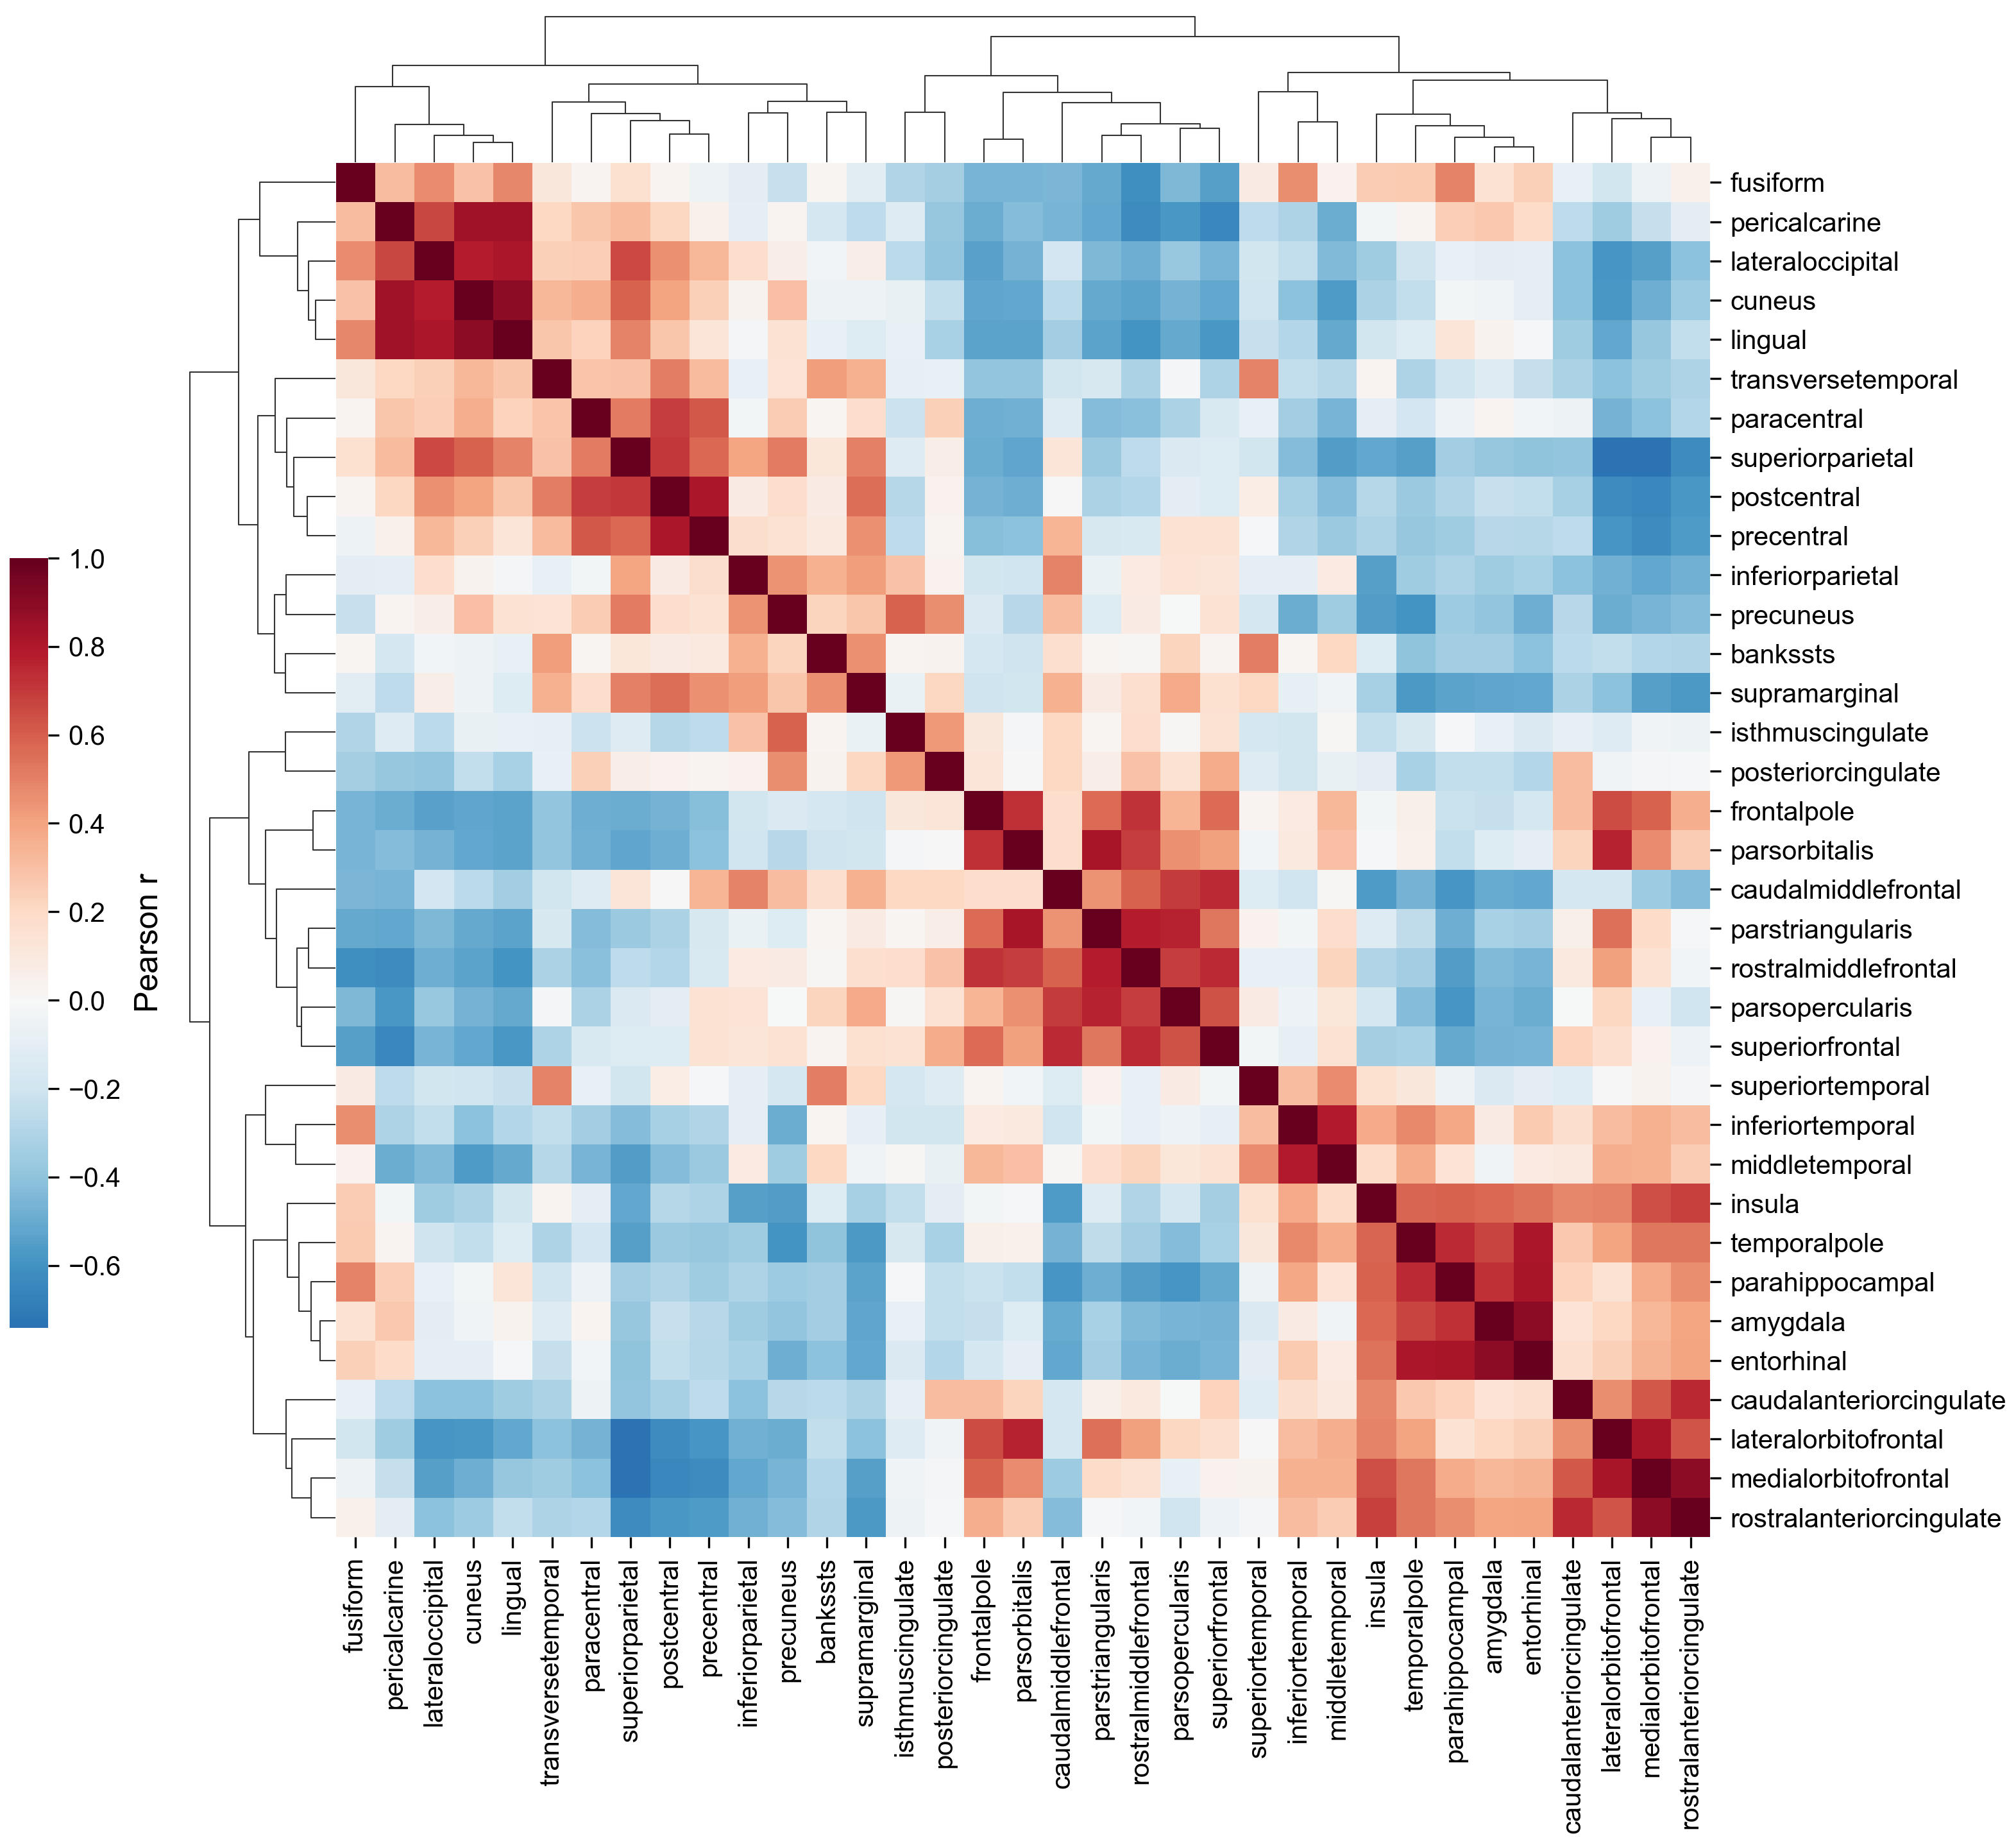

In [252]:
# Plot a correlation matrix of zsuvr values across levels of dat["roi"] with hierarchical clustering.
savefig = True
overwrite = True
corrdat = dat.pivot(index="subj", columns="roi", values="zsuvr").corr()
plt.close("all")
# sns.heatmap(corrdat, cmap="RdBu_r", center=0, square=True, cbar_kws={"label": "Pearson r"})
cg = sns.clustermap(
    corrdat,
    cmap="RdBu_r",
    center=0,
    figsize=(10, 10),
    dendrogram_ratio=(.1, .1),
    cbar_pos=(-0.075, .3, .02, .4),
    cbar_kws={"label": "Pearson r"},
)
# Drop the axis titles
cg.ax_heatmap.set_xlabel("")
cg.ax_heatmap.set_ylabel("")

# Save the figure.
if savefig:
    outf = op.join(proj_dir, "figs", "clustering", "hclus_corrmat_zsuvr_{}bilat-fsroi_{}eoad_visit1_{}.pdf".format(dat["roi"].nunique(), dat["subj"].nunique(), today()))
    if overwrite or not op.isfile(outf):
        cg.savefig(outf)
        print(f"Saved {outf}")

/Users/dschonhaut/mambaforge/envs/nipy310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/dschonhaut/mambaforge/envs/nipy310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Saved /Users/dschonhaut/box/projects/leads_tau_spread/figs/clustering/hclus_suvr_35bilat-fsroi_379eoad_visit1_2024-02-15.pdf


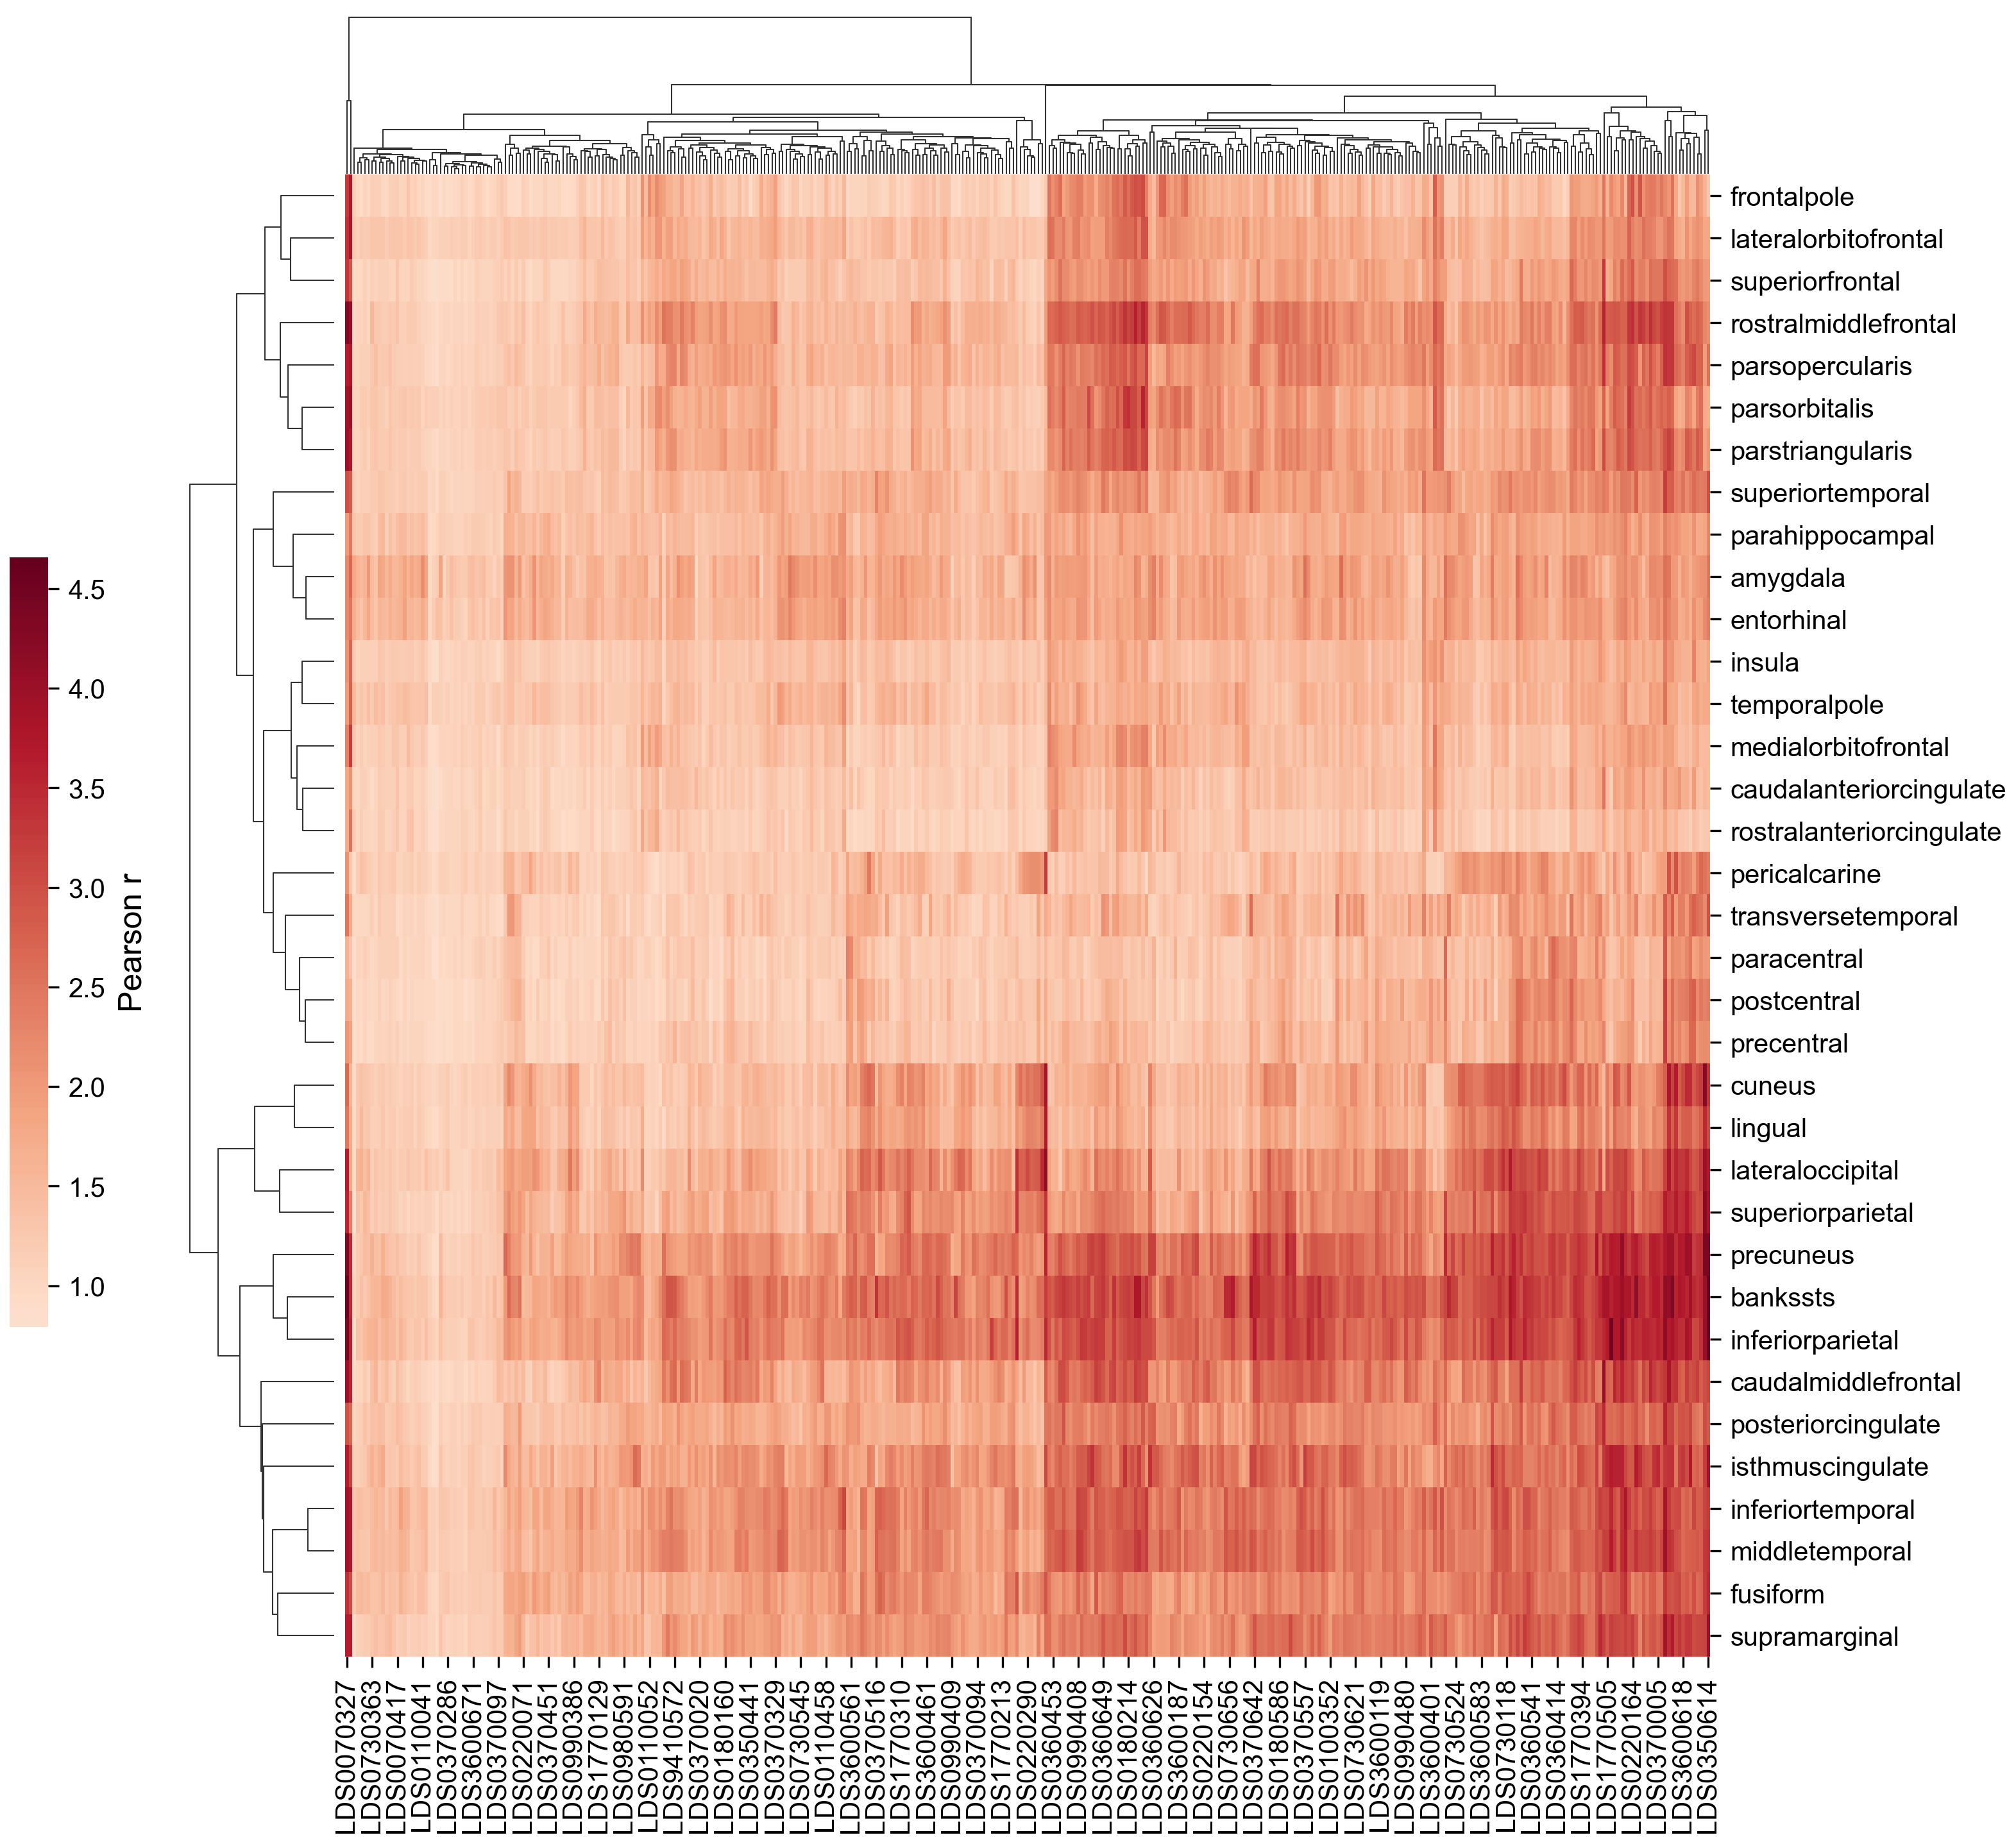

In [253]:
# Plot a correlation matrix of zsuvr values across levels of dat["roi"] with hierarchical clustering.
savefig = True
overwrite = True
pdat = dat.pivot(index="subj", columns="roi", values="suvr")
plt.close("all")
# sns.heatmap(corrdat, cmap="RdBu_r", center=0, square=True, cbar_kws={"label": "Pearson r"})
cg = sns.clustermap(
    pdat.T,
    cmap="RdBu_r",
    center=0,
    figsize=(10, 10),
    dendrogram_ratio=(.1, .1),
    cbar_pos=(-0.075, .3, .02, .4),
    cbar_kws={"label": "Pearson r"},
)
# Drop the axis titles
cg.ax_heatmap.set_xlabel("")
cg.ax_heatmap.set_ylabel("")

# Save the figure.
if savefig:
    outf = op.join(proj_dir, "figs", "clustering", "hclus_suvr_{}bilat-fsroi_{}eoad_visit1_{}.pdf".format(dat["roi"].nunique(), dat["subj"].nunique(), today()))
    if overwrite or not op.isfile(outf):
        cg.savefig(outf)
        print(f"Saved {outf}")

/Users/dschonhaut/mambaforge/envs/nipy310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/dschonhaut/mambaforge/envs/nipy310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Saved /Users/dschonhaut/box/projects/leads_tau_spread/figs/clustering/hclus_zsuvr_35bilat-fsroi_379eoad_visit1_2024-02-15.pdf


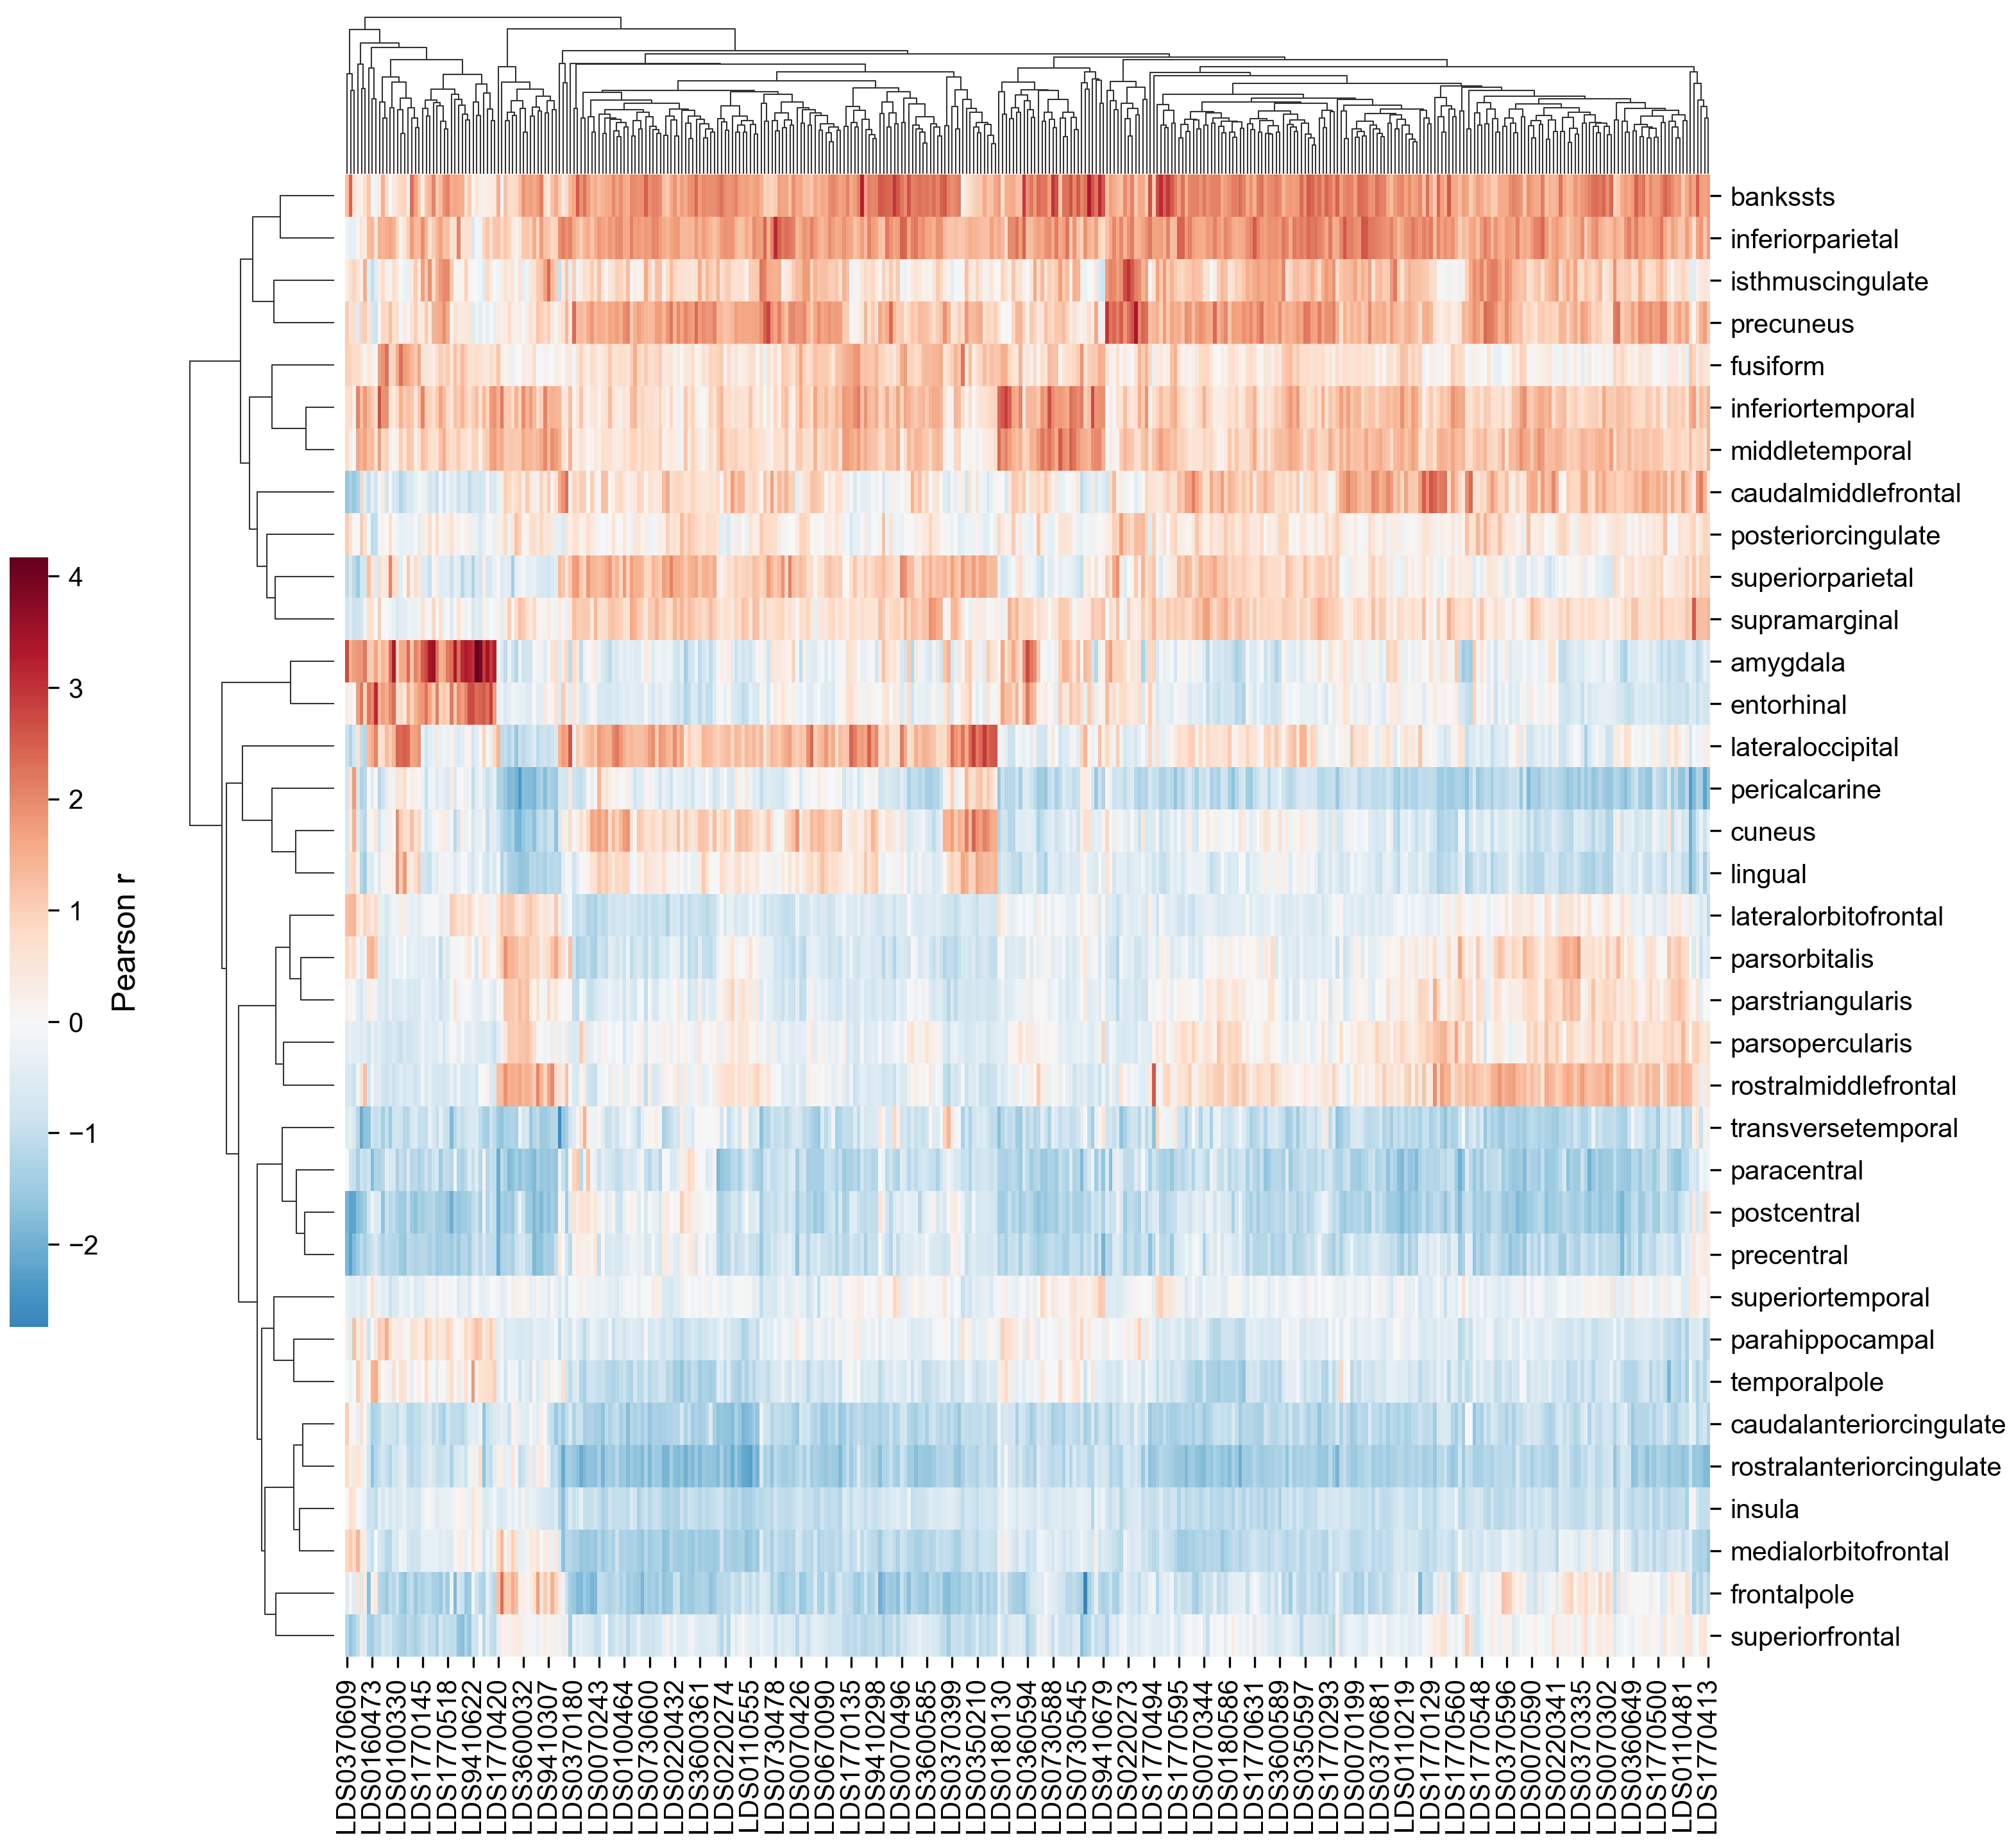

In [254]:
# Plot a correlation matrix of zsuvr values across levels of dat["roi"] with hierarchical clustering.
savefig = True
overwrite = True
pdat = dat.pivot(index="subj", columns="roi", values="zsuvr")
plt.close("all")
# sns.heatmap(corrdat, cmap="RdBu_r", center=0, square=True, cbar_kws={"label": "Pearson r"})
cg = sns.clustermap(
    pdat.T,
    cmap="RdBu_r",
    center=0,
    figsize=(10, 10),
    dendrogram_ratio=(.1, .1),
    cbar_pos=(-0.075, .3, .02, .4),
    cbar_kws={"label": "Pearson r"},
)
# Drop the axis titles
cg.ax_heatmap.set_xlabel("")
cg.ax_heatmap.set_ylabel("")

# Save the figure.
if savefig:
    outf = op.join(proj_dir, "figs", "clustering", "hclus_zsuvr_{}bilat-fsroi_{}eoad_visit1_{}.pdf".format(dat["roi"].nunique(), dat["subj"].nunique(), today()))
    if overwrite or not op.isfile(outf):
        cg.savefig(outf)
        print(f"Saved {outf}")

Saved /Users/dschonhaut/box/projects/leads_tau_spread/figs/clustering/hdbscan_min-clus-2_35bilat-fsroi_379eoad_visit1_2024-02-15.pdf


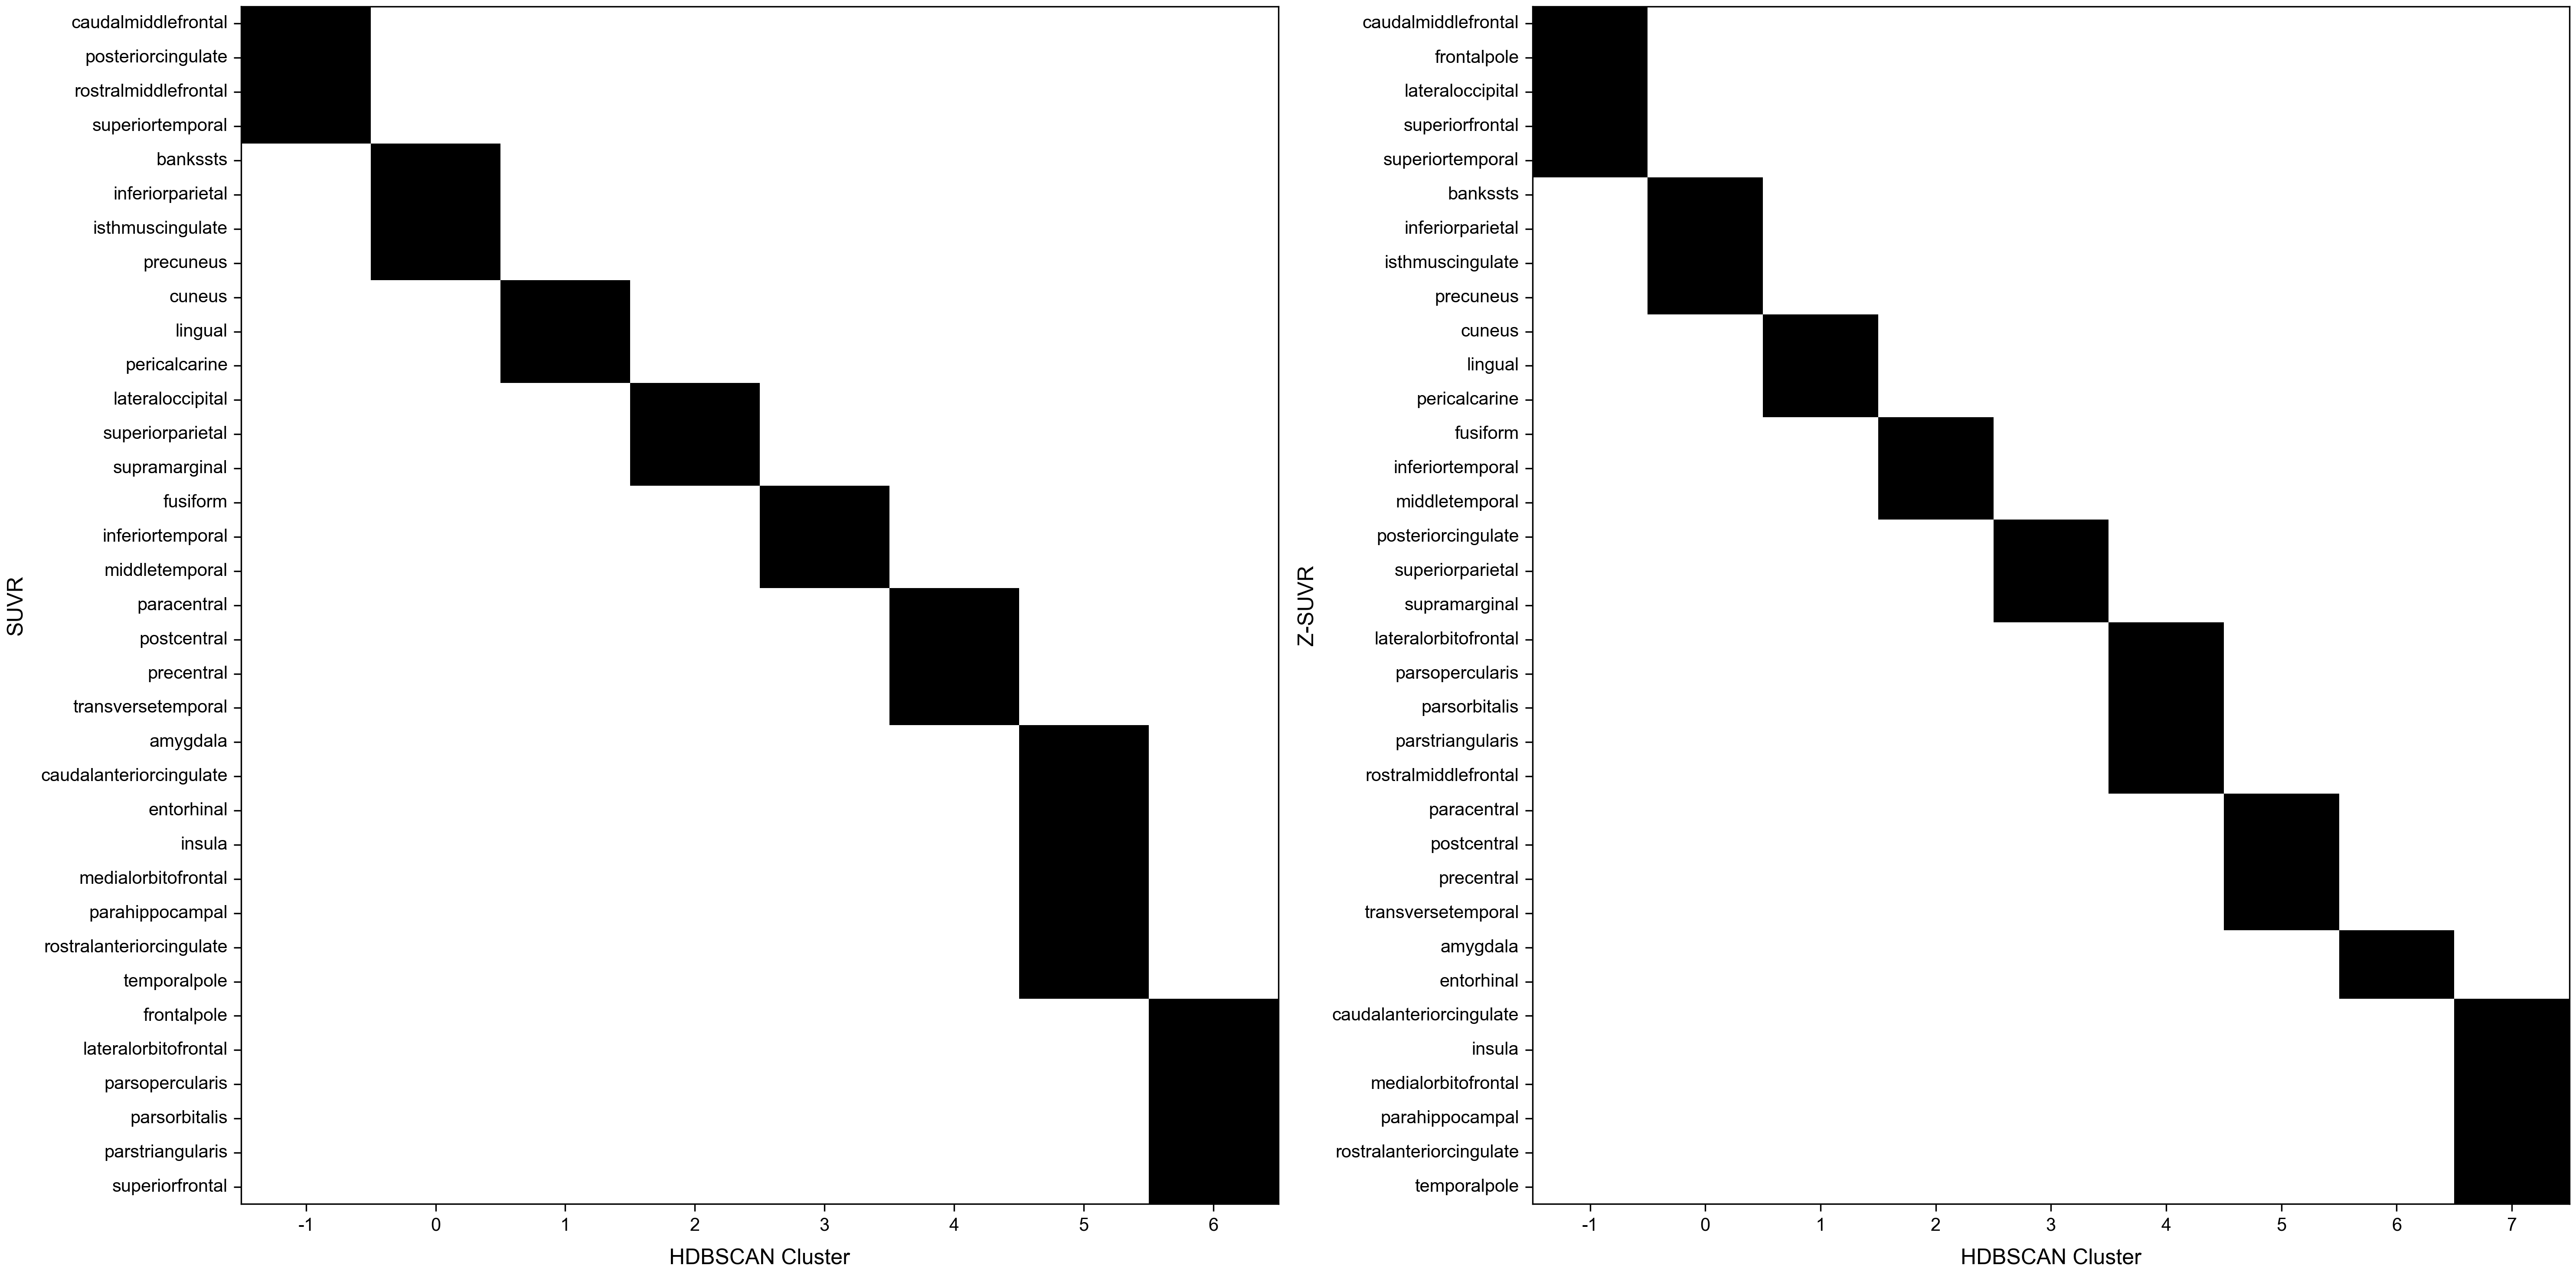

In [256]:
savefig = True
overwrite = True
cmap = ["w", "k"]
fig, ax = plt.subplots(1, 2, figsize=(20, 10), dpi=300)
ax = ax.ravel()
min_clus = 2

# ---------------------------------------------
iax = 0
_ax = ax[iax]
val = "suvr"
datw = pd.pivot(
    dat,
    index="subj",
    columns="roi",
    values=val
)

hdb = HDBSCAN(min_cluster_size=min_clus)
hdb.fit(datw.T)
roi_clus = (
    pd.DataFrame(
        np.vstack((
            datw.T.index.values,
            hdb.labels_,
            hdb.probabilities_,
        )).T,
        columns=[
            "roi",
            "cluster",
            "cluster_pr",
        ]
    )
    .sort_values(["cluster", "roi"])
    .reset_index(drop=True)
)
sns.heatmap(
    (
        roi_clus
        .groupby(["roi", "cluster"])
        .size()
        .unstack()
        .fillna(0)
        .astype(int)
        .sort_values(np.arange(roi_clus["cluster"].min(), roi_clus["cluster"].max()).tolist(), ascending=False)
    ),
    square=False,
    cmap=cmap,
    cbar=False,
    ax=_ax
)
_ax.set_ylabel("SUVR", labelpad=8)
# _ax.set_title(f"{val.upper()} (min cluster size = {min_clus})")

# ---------------------------------------------
iax += 1
_ax = ax[iax]
val = "zsuvr"
datw = pd.pivot(
    dat,
    index="subj",
    columns="roi",
    values=val
)

hdb = HDBSCAN(min_cluster_size=min_clus)
hdb.fit(datw.T)
roi_clus = (
    pd.DataFrame(
        np.vstack((
            datw.T.index.values,
            hdb.labels_,
            hdb.probabilities_,
        )).T,
        columns=[
            "roi",
            "cluster",
            "cluster_pr",
        ]
    )
    .sort_values(["cluster", "roi"])
    .reset_index(drop=True)
)
sns.heatmap(
    (
        roi_clus
        .groupby(["roi", "cluster"])
        .size()
        .unstack()
        .fillna(0)
        .astype(int)
        .sort_values(np.arange(roi_clus["cluster"].min(), roi_clus["cluster"].max()).tolist(), ascending=False)
    ),
    square=False,
    cmap=cmap,
    cbar=False,
    ax=_ax
)
_ax.set_ylabel("Z-SUVR", labelpad=8)
# _ax.set_title(f"{val.upper()} (min cluster size = {min_clus})")

for _ax in ax:
    _ax.set_xlabel("HDBSCAN Cluster", labelpad=8)
    _ax.spines["top"].set_visible(True)
    _ax.spines["right"].set_visible(True)
    _ax.spines["bottom"].set_visible(True)
    _ax.spines["left"].set_visible(True)

# Save the figure.
if savefig:
    outf = op.join(proj_dir, "figs", "clustering", "hdbscan_min-clus-{}_{}bilat-fsroi_{}eoad_visit1_{}.pdf".format(min_clus, dat["roi"].nunique(), dat["subj"].nunique(), today()))
    if overwrite or not op.isfile(outf):
        fig.savefig(outf)
        print(f"Saved {outf}")

In [13]:
keep_parcs = ["metarois", "earlyrois"]
keep_parcs = ["fsroi_bilat"]
tau_all_agg.query("(dx=='EOAD') & (parc in @keep_parcs) & (visit==1)")["roi"].unique()

array(['frontal', 'parietal', 'temporal', 'bltemp', 'cmfg', 'medp', 'mtl',
       'tpj'], dtype=object)

In [4]:
# Import ROI extraction and CDR data.
tau_all_agg = pd.read_csv(op.join(ssheet_dir, "tau-rois-agg_2024-02-06.csv"))
tau_eoad = pd.read_csv(op.join(ssheet_dir, "tau-rois-agg_eoad-long_2024-02-06.csv"))
cdr_eoad = pd.read_csv(
    op.join(ssheet_dir, "cdr-sb_eoad-long_formatted_193subjs_2023-12-30.csv")
)
assert False

# Find subjects with 1+ CDR scores and 2+ FTP scans
eoad_long_subjs = np.intersect1d(
    tau_eoad.query("(ftp_visits>1)")["subj"], cdr_eoad["subj"]
)
tau_eoad = tau_eoad.query("(subj in @eoad_long_subjs)").reset_index(drop=True)
cdr_eoad = cdr_eoad.query("(subj in @eoad_long_subjs) & (cdr_visits>1)").reset_index(
    drop=True
)

# Add suvr_last column to tau_eoad
tau_eoad["suvr_last"] = (
    tau_eoad.sort_values(["subj", "roi", "visit"])
    .groupby(["subj", "roi"])["suvr"]
    .shift(1)
)
tau_eoad["vol_last"] = (
    tau_eoad.sort_values(["subj", "roi", "visit"])
    .groupby(["subj", "roi"])["vol"]
    .shift(1)
)

print(f"tau_eoad: {tau_eoad.shape}")
print(f"cdr_eoad: {cdr_eoad.shape}")
print(f"{len(eoad_long_subjs)} EOAD subjects with 2+ FTP scans and 1+ CDR scores")

AssertionError: 

In [21]:
# Format everything in one dataframe before modeling.
cols = [
    "subj",
    "visit",
    "key",
    "val_last",
    "val_annchg",
]
data = []
_data = cdr_eoad.loc[
    :, ["subj", "visit", "cdr_sb_last", "cdr_sb_annchg_from_last"]
].copy()
_data.insert(2, "key", "cdr_sb")
_data.columns = cols
data.append(_data)

_data = (
    tau_eoad.query("(parc==['metarois', 'earlyrois'])")
    .reset_index(drop=True)
    .loc[:, ["subj", "visit", "roi", "suvr_last", "suvr_annchg_from_last"]]
    .copy()
)
_data.columns = cols
data.append(_data)

data = (
    pd.concat(data, axis=0).sort_values(["key", "subj", "visit"]).reset_index(drop=True)
)
print(f"data: {data.shape}")
print(f"{data['subj'].nunique()} subjects, {data['key'].nunique()} keys")

data: (4242, 5)
187 subjects, 9 keys


In [22]:
data.head()

,subj,visit,key,val_last,val_annchg
0,LDS0070166,1,bltemp,NaN,NaN
1,LDS0070166,2,bltemp,3.052760,-0.345061
2,LDS0070166,3,bltemp,2.687151,0.150959
3,LDS0070166,4,bltemp,2.857845,-0.310755
4,LDS0070174,1,bltemp,NaN,NaN


In [ ]:
class Trails(object):
    def __init__(self, data):
        self.data = data
        self.trails = self.fit_trails()

    def get_trails(self):
        trails = self.tau_all_agg.query("roi == 'Trails'")
        trails = trails.query("age >= 50")
        trails = trails.query("age <= 90")
        trails = trails.query